# Introducción a los Polinomios y Splines de Regresión

Extraido y adaptado por [Pedro González Rodelas](https://www.ugr.es/~prodelas) del artículo *Introduction to Regression Splines (with Python codes)* en el Blog de [Analytics Vidhya](https://www.analyticsvidhya.com/blog/).

Fecha de la primera versión: 06/03/2022

Sucesivas revisiones: 28-30/03/2022

Fecha de la última revisión: 30/3/2023

Con el objeto de intentar simplificar las cosas se suele asumir una relación lineal entre las variables estadísticas dependientes e independientes, lo que rara vez es el caso en realidad. 

Así pues, como mejora con respecto a este modelo, cabría probar también la regresión polinómica, que (la mayoría de las veces) suele generar mucho mejores resultados. 

Pero el uso de la regresión polinómica en conjuntos de datos con altas posibilidades de variabilidad puede llegar a resultar en un sobreajuste con  excesivas oscilaciones, tal y como solía pasar con las técnicas de interpolación polinómica (ver los siguientes ejemplos gráficos).

In [1]:
# %ls *.png

![imagen](overfit.png)
Fuente: Pingax

Así pues, estos modelos de regresión polinomiales se pueden volver demasiado flexibles y oscilantes, lo que no funciona bien con datos *no bien correlacionados*. Pero en todo caso, aunque se usen polinomios de grado mayor que uno para el correspondiente ajuste como tal, siguen teniendo un carácter eminentemente lineal

Eso no quita que haya otros enfoques más complejos o sofisticados (con cierto carácter no lineal) conocidos de manera general como Regresión con Splines, que utilizan una combinación de funciones polinómicas a trozos para ajustarse a los datos.

En este notebook, repasaremos en primer lugar algunos conceptos básicos de la regresión lineal y polinómica, y posteriormente estudiaremos en detalle el significado y uso de splines, así como su implementación en Python.

# Introducción


Cualquier recién llegado al mundo de la Ciencia de Datos, se ve enfrentado en un primer momento con el algoritmo de la Regresión Lineal. Pero en cuanto dicho algoritmo es aplicado a diferentes conjuntos de datos, se pueden distinguir claramente tanto sus ventajas como sus innegables limitaciones.

De partida, en una Regresión de tipo lineal, necesariamente una relación de ese tipo es asumida entre las variables dependiente e independente, que es raramente el caso en la práctica. Por lo tanto, una cierta mejora de este modelo supondría probar con Regresiones de tipo Polinomial (con grado superior a uno), que podrían generar resultados mejores (en la mayoría de los casos). Pero numerosos ejemplos también muestran que, usando Regresión Polinomial con conjuntos de datos con gran variabilidad, resulta muy probable caer en cierto grado de sobre-ajuste (over-fitting en inglés).

En efecto, estos modelos de Regresión Polinomial suelen volverse demasiado flexibles y oscilantes, lo que no funciona bien con datos menos relevantes. Por ese motivo, otra de las opciones para la Regresión de tipo No Lineal sería la Regresión con Splines. Consiste en usar una combinación de funciones polinomiales a trozos para intentar ajustar mejor dichos datos.

En este notebook exploraremos pues los conceptos y procedimientos básicos tanto de la regresión de tipo lineal como polinomial (en general), y estudiaremos también en detalle el significado y el uso de splines, así como su implementación en Python.
 

Índice de Contenidos:

* Entendiendo los Datos
* Rápida revisión de la Regresión Lineal
* Regresión Polinomial: mejora sobre la Regresión de tipo Lineal
* Tutorial de splines de regresión junto con sus implementaciones
* Funciones escalonadas a trozos
* Funciones de base
* Polinomios a trozos: splines
* Restricciones de los diferentes Splines
* Splines cúbicos y cúbicos naturales
* Elegir el número y la ubicación de los nodos
* Comparación de splines de regresión con polinomios de regresión

Para entender los conceptos, trabajaremos en el conjunto de datos de predicción salarial que puede descargar [aquí](https://drive.google.com/file/d/1QIHCTvHQIBpilzbNxGmbdEBEbmEkMd_K/view) (esto ha sido tomado de un popular libro sobre ["An Introduction to Statistical Learning with Applications in R"](https://link.springer.com/book/10.1007/978-1-4614-7138-7).

Nuestro conjunto de datos contiene información como la identificación, el año, la edad, el sexo, el estado civil, la raza, la educación, la región, la clase de trabajo, la salud, el seguro de salud, el registro de salario y el salario de varios empleados. Para centrarme en la regresión spline en detalle, usaré solo 'edad' como variable independiente para predecir el salario (variable dependiente).

Comencemos a trabajar con los datos.

In [2]:
# importamos los módulos
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# leemos los conjuntos de datos
data = pd.read_csv("Wage.csv")

data.head()

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


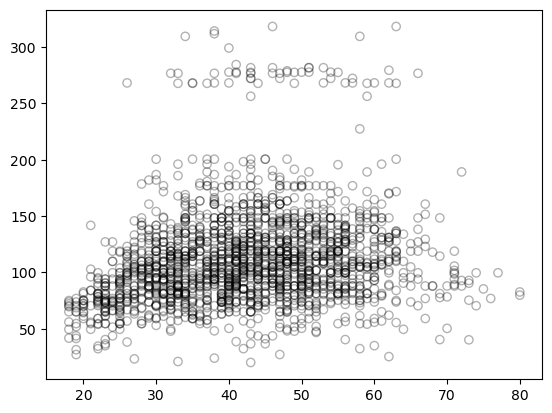

In [4]:
data_x = data['age']
data_y = data['wage']

# Dividimos los datos en dos subgrupos: de entrenamiento y validación
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

# Visualizamos ahora la relación entre edad y sueldo (age y wage)
import matplotlib.pyplot as plt   # mediante un gráfico en blanco y negro
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

Ciertamente, la Regresión Lineal es la técnica estadística más
simple y la más ampliamente usada para la modelización predictiva. Es un algoritmo de aprendizaje supervisado para resolver tareas basadas en regresión.

Se llama modelo lineal, ya que establece una relación lineal entre las variables dependientes e independientes.

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 +\ldots+ \beta_p X_p$$

Aquí tenemos $Y$ como nuestra variable dependiente, los valores de $X$ serán de la variable independente, mientras que los $\beta $s serán los  coeficientes del modelo (dichos coeficientes son los pesos asignados a las características del mismo, e indican la importancia de cada una de ellas). 

Por ejemplo, si el resultado de una ecuación depende en gran medida de una característica ($X_1$) en comparación con cualquier otra característica, significa que el coeficiente/peso de la característica ($X_1$) tendría una magnitud mayor en comparación con cualquier otra característica.

Entonces, intentemos entender la regresión lineal con una sola característica; es decir, solo una variable independiente. Se llama regresión lineal simple. Por lo tanto, nuestra ecuación se convierte en:

$$Y = \beta_0 + \beta_1 X_1$$

Como solo usamos la "edad" (age) para predecir los "salarios" (wage) de los empleados, implementaremos una regresión lineal simple en el conjunto de datos de capacitación y calcularemos el error (RMSE) en el conjunto de datos de validación.

In [5]:
from sklearn.linear_model import LinearRegression
# Empezamos importando el modelo de Regresión Lineal dentro de sklearn
# y realizamos el ajuste de regresión lineal del modelo
x = train_x.values.reshape(-1,1)
model = LinearRegression()
model.fit(x,train_y)
print(model.coef_)
print(model.intercept_)

[0.72190831]
80.65287740759283


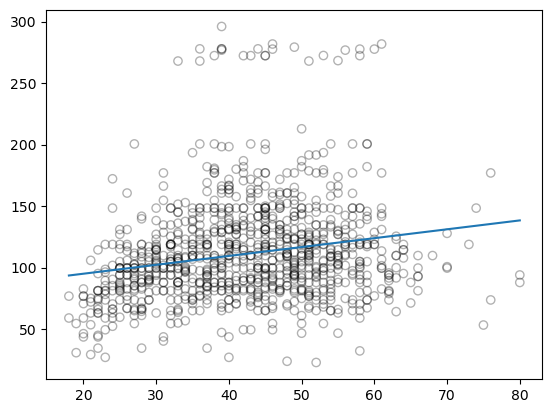

In [6]:
# Y ahora realizamos la Predicción sobre el conjunto de validación
valid_x = valid_x.values.reshape(-1,1)
pred = model.predict(valid_x)

# Visualización
# Usaremos 70 puntos entre los valores mínimo y máximo de los x's
xp = np.linspace(valid_x.min(),valid_x.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# finalmente calculamos e imprimimos el error cuadrático medio
rms = sqrt(mean_squared_error(valid_y, pred))
print(rms)

40.436687488017256


De esta manera podremos inferir de los gráficos anteriores que la regresión lineal no está capturando todas las señales disponibles y no es el mejor método para resolver esta predicción salarial.

Aunque los modelos lineales son relativamente simples de describir e implementar, y tienen ventajas sobre otros enfoques en términos de interpretación e inferencia, tienen limitaciones significativas en términos de poder predictivo. Esto se debe a que asumen la combinación lineal entre las variables dependientes e independientes, que casi siempre es una mera aproximación y, a veces, bastante pobre.

En los otros métodos que veremos a continuación, dejaremos de lado la suposición de linealidad, mientras intentamos mantener la mayor interpretabilidad posible. Haremos esto examinando extensiones muy simples de modelos lineales como regresión polinomial y funciones escalonadas, así como enfoques más sofisticados como el uso de splines.

## Mejoras sobre la Regresión Lineal: Regresión Polinomial

![imagen.png](regresion-polinomial.png)

Los gráficos anteriores parecen estar usando mucha más información entre el salario y la edad, en comparación con el gráfico lineal. Estos gráficos ya no tienen forma lineal, por lo que utilizan una ecuación no lineal en lugar de una ecuación lineal para establecer la relación entre la edad y el salario. Este tipo de técnica de regresión, que utiliza una función no lineal sino una de tipo polinómico, se denomina pues regresión polinómica. 

La regresión polinomial amplía el modelo lineal al agregar predictores adicionales, obtenidos al elevar cada uno de los predictores originales a una potencia. Por ejemplo, una regresión cúbica utiliza tres de estas potencias como variables predictoras (aparte de las constantes, generadas por $1\equiv X^0$):

$$ X, X^2, X^3 $$

Este enfoque proporciona una forma sencilla de proporcionar un ajuste no lineal a los datos. El método estándar para extender la regresión lineal a una relación no lineal entre las variables dependientes e independientes ha sido reemplazar el modelo lineal con una función polinomial

$$ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \ldots + \beta_p X^p $$

In [8]:
# Generando los pesos (coefs.) para una función polinomial de grado 3
weights = np.polyfit(train_x, train_y, 3)
print(weights)

[ 6.29073869e-04 -1.36805158e-01  8.82469303e+00 -5.74157278e+01]


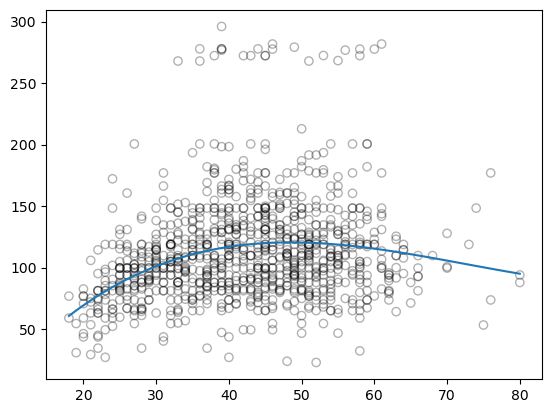

In [9]:
# Generando el modelo con los pesos (o coeficientes) obtenidos
model = np.poly1d(weights)

# Predicción sobre el conjunto de validación
pred = model(valid_x)
# Obtenemos ahora el gráfico para 70 observaciones sólamente
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

A medida que aumentamos el valor de la potencia, la curva obtenida contiene altas oscilaciones que darán lugar a formas demasiado flexibles. Tales curvas conducen a veces a un ajuste demasiado excesivo, como puede verse en las gráficas siguientes.

![imagen.png](regresion-polinomial-d4.png)

![imagen-2.png](regresion-polinomial-d12.png)

![imagen-3.png](regresion-polinomial-d16.png)

![imagen-4.png](regresion-polinomial-d25.png)

Desafortunadamente, la regresión polinómica también tiene un buen número de problemas. A medida que aumentamos la complejidad o grado de la fórmula, el número de oscilaciones también aumenta, lo que a veces es difícil de manejar. Además, la regresión polinómica tiene una tendencia a sobreajustarse drásticamente, incluso en este simple conjunto de datos unidimensionales.

Hay otros problemas con la regresión polinómica. Por ejemplo, es inherentemente no local, es decir, cambiar el valor de $Y$ en un punto del conjunto de entrenamiento puede afectar el ajuste del polinomio para puntos de datos que están muy lejos. Por lo tanto, para evitar el uso de polinomios de alto grado en todo el conjunto de datos, podemos sustituirlo con muchas funciones polinómicas diferentes de pequeño grado.

# Ajustes mediante Splines de Regresión,  junto con sus implementaciones

Para superar las desventajas de la regresión polinómica, podemos utilizar una técnica de regresión mejorada que, en lugar de construir un modelo para todo el conjunto de datos, divide el conjunto de datos en múltiples partes o secciones, y ajusta cada parte con un modelo separado. Tal técnica se conoce como spline de regresión.

Los splines de regresión son una de las técnicas de regresión no lineal más importantes. En este tipo de regresión, generamos nuevos ajustes mediante el uso de varias funciones polinómicas en las porcioness existentes, que configurarán la estructura global en el conjunto de datos. Así pues la idea es la de dividir la distribución de los datos en porciones separadas y ajustar funciones polinómicas (lineales o de bajo grado) en cada una de estas porciones.

![imagen.png](spline_example.png)

Fuente: R-Bloggers

Los puntos donde se produce la división entre una porción y otra se denominan nodos. Las funciones que podemos utilizar para modelar cada porción se conocen como funciones definidas a trozos (piecewise en inglés). Hay varias funciones por partes que podemos usar para adaptarse a estas porciones individuales.

En las siguientes subsecciones, veremos algunas de estas funciones por partes que conforman los diferentes tipos de splines de ajuste más habituales.

# Usando funciones definidas a trozos

Una de las funciones por partes más comunes es una función discontinua de tipo salto (constante a trozos). Este tipo de función escalonada es una función que permanece constante dentro de cada subintervalo. Podemos ajustar pues funciones de salto independientes para cada uno de los subintervalos en los que dividimos el intervalo global. Aquí dividimos el rango de la variable $X$ en porciones, y ajustamos una constante diferente en cada una de ellas.

Con más detalle, creamos varios puntos de corte $c_1, c_2, \ldots, c_k$  en el rango de variabilidad de $X$, y a partir de estos construimos $K+1$ nuevas variables

$$
C_0(X) = I(X<c_1),\\
C_1(X) = I(c_1\leq X<c_2),\\
C_2(X) = I(c_2\leq X<c_3),\\
\vdots \\
C_{K-1}(X) = I(c_{K-1}\leq X<c_K),\\
C_K(X)  = I(c_K\leq X)
$$

donde $I( )$ es una función indicadora, que devuelve $1$ si la condición del interior es verdadera, mientras que devolverá $0$ en caso contrario. Por ejemplo, $I(c_K \leq X )$ será $1$ si $c_K \leq X$; en caso contrario será $0$. Para cierto valor de $X$ dado, a lo sumo solo una de las porciones $C_1, C_2, \ldots, C_K$  podrá ser distinta de cero, ya que  $X$ solo podrá estar en uno de los correspondientes subintervalos.

Estas subdivisiones en el rango de la variable independiente $X$ tiene también sus problemas conceptuales obvios. De manera más prominente, esperamos que la mayoría de los fenómenos que estudiamos varíen continuamente con las entradas. La regresión agrupada no crea automáticamente funciones continuas del predictor, por lo que en la mayoría de los casos no esperaríamos ninguna relación continua entre la entrada y la salida.

In [10]:
# Dividiendo los datos en 4 subintervalos
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [11]:
df_steps = pd.concat([train_x, df_cut, train_y], 
                 keys=['age','age_cuts','wage'], axis=1)

# Creamos variables ficticias para los grupos de edad 
# (ya que queremos evitar las variables categóricas)
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


Uso de [Modelos Lineales Generalizados](https://es.wikipedia.org/wiki/Modelo_lineal_generalizado)

In [12]:
valid_x = valid_x.flatten()

In [13]:
# Subdividiendo el conjunto de validación en 4 subintervalos iguales
bin_mapping = np.digitize(valid_x, bins) 

In [14]:
df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80'] 

# Ajustando con Modelos Lineales Generalizados (GLMs)
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

In [15]:
fit3

In [16]:
bins

array([17.938, 33.5  , 49.   , 64.5  , 80.   ])

In [17]:
# Quitamos los outliers
X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)

# Predicción
pred2 = fit3.predict(X_valid)

# Calculando el error cuadrático medio (RMSE)
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid_y, pred2)) 
print(rms) 

39.990600783110395


In [18]:
# Calculando el error cuadrático medio (RMSE)
from sklearn.metrics import mean_squared_error 
from math import sqrt 

In [19]:
# Mostraremos ahora la gráfica para las 70 observaciones solamente
xp = np.linspace(valid_x.min(),valid_x.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)

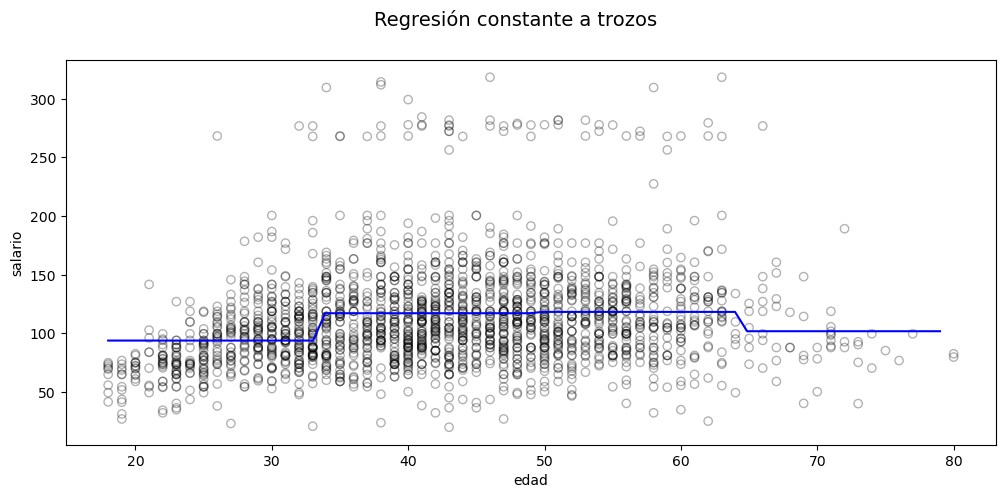

In [20]:
# Visualización
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Regresión constante a trozos', fontsize=14)

# Gráfico de dispersión de los datos y la regresión constante a trozos
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('edad')
ax1.set_ylabel('salario')
plt.show()

# Funciones de base de los splines

Para capturar la no linealidad en los modelos de regresión, necesitamos transformar algunos o todos los predictores. Para evitar tener que tratar cada predictor como lineal, queremos aplicar una familia muy general de transformaciones a nuestros predictores. La familia debe ser lo suficientemente flexible como para adaptarse (cuando el modelo está ajustado) a una amplia variedad de formas, pero no demasiado como para sobreajustarse.

Este concepto de una familia de transformaciones que pueden usarse conjuntamente para capturar formas más generales se llaman funciones de base. En este caso, nuestros objetos serán funciones: $b_1(X ), b_2 (X ), \ldots , b_K(X )$.

Ahora, en vez de ajustar un modelo lineal para $X$, ajustaremos el siguiente modelo:

$$ Y = \beta_0 + \beta_1 b_1(X) + \beta_2 b_2(X) + \ldots + \beta_K b_K(X) $$

Ahora veremos una opción muy común para la elección de estas funciones de base: **polinomios a trozos**.

# Uso de funciones polinómicas a trozos

En lugar de ajustar una función constante sobre diferentes subintervalos en todo el rango de $X$, la regresión polinómica a trozos implica ajustar polinomios separados de bajo grado en diferentes regiones del rango de $X$. Como usamos polinomios de grado bajo, no observamos altas oscilaciones de la curva alrededor de los datos.

Por ejemplo, un polinomio cuadrático a trozos funciona ajustando una ecuación de regresión cuadrática:

$$ Y = \beta_0 + \beta_1  X +\beta_2 X^2 $$

donde los coeficientes $β_0, β_1$ y $β_2$ difieren en diferentes partes del rango de $X$. 

Por ejemplo un spline cúbico, con un simple nodo en el punto $c$, tomaría la siguiente forma:

$$
Y =
\beta_{01} + \beta_{11} X + \beta_{21} X^2 + \beta_{31} X^3,  \text{si } X < c\\
\beta_{02} + \beta_{12} X + \beta_{22} X^2 + \beta_{32} X^3,  \text{si } X \geq c 
$$

en otras palabras, en este caso ajustaríamos dos funciones polinómicas diferentes a los datos: una sobre el subconjunto de observaciones con $X < c$, y otro sobre el subconjunto de observaciones con $X ≥ c$.

Cada una de estas funciones polinomiales podría ser ajustada usando la métrica habitual de mínimos cuadrados del error.

La primera función polinomial tendrá coeficientes $β_{01}, β_{11}, β_{21}, β_{31}$ y el segundo tendrá coeficientes $β_{02}, β_{12}, β_{22}, β_{32}$. 
Nótese que esta familia de 2 funciones polinómicas cúbicas tiene 8 grados de libertad, 4 para cada polinomio (ya que hay 4 coeficientes a determinar por cada uno de ellos).

El uso de más nodos conduce a un polinomio a trozos (o spline) más flexible, ya que utilizamos diferentes funciones para cada subintervalo, de manera que estos trozos polinómicos dependen solo de la distribución de datos en ese subintervalo en particular. En general, si colocamos $K$ nodos interiores diferentes en todo el rango de la variable $X$, acabaremos encajando $K+1$ diferentes polinomios cúbicos. Podemos usar cualquier polinomio de bajo grado para ajustar estos trozos individuales. Por ejemplo, podemos ajustar funciones lineales por a trozos, cuadráticas, etc.

De hecho, las funciones constantes a trozos usados más arriba son realmente funciones polinómicas de grado 0.

Ahora revisaremos algunas condiciones y restricciones necesarias que deben seguirse al formar splines o polinomios por partes, que dependerán sobre todo del grado de regularidad global que queramos obtener.

# Restricciones asociadas a los diferentes tipos de splines

Debemos ser cautelosos al usar splines, ya que hay varias restricciones que debemos seguir. Considere la imagen a continuación:


![imagen.png](splines-discontinous.png)

Fuente de la imagen: Elements of Statistical Learning

Podemos encontrar ciertas situaciones en las que los polinomios a cada lado de un nodo interior no son continuos en el nodo. Tal condición debe evitarse porque la familia de polinomios en su conjunto debe generar una salida única para cada entrada.

![imagen-2.png](splines-continous.png)
Fuente de la imagen: Elements of Statistical Learning

Podemos ver en la imagen de arriba que en el primer nodo se tendrían dos valores diferentes, perdiéndose la continuidad. Por lo tanto, para evitar esto, debemos agregar una restricción, o condición adicional, a imponer a los polinomios a cada lado de un nodo, para que el spline siga siendo continuo en el nodo.

Ahora, después de agregar esa restricción, obtenemos una familia continua de polinomios a trozos (denominado spline). 

Pero ahora la pregunta que nos podríamos hacer sería la siguiente: ¿se ve perfecto? Piense en lo que faltaría todavía: parece que la suavidad (o regularidad de las derivadas) en los nodos todavía está ausente.

Así que para suavizar los polinomios en los nodos, tendremos que añadir una restricción/condición adicional por cada derivada que queramos que sea continua en dicho nodo.

Por ejemplo, para que el spline resultante sea de clase al menos $\mathcal{C}ˆ1$, entonces la primera derivada de los polinomios a ambos lados del nodo debe ser la misma. Una cosa que debemos tener en cuenta es que cada restricción que imponemos a los trozos de polinomios cuadráticos o cúbicos del spline libera efectivamente un grado de libertad, ya que reducimos la complejidad del ajuste polinómico a trozos resultante. Por lo tanto, en la gráfica anterior, estamos usando solo 10 grados de libertad en lugar de 12.

![imagen-3.png](splines-C1.png)
Fuente de la imagen: Elements of Statistical Learning


Después de imponer la restricción de igualdad de la primera derivada, obtenemos la gráfica anterior. Esta gráfica utiliza 8 grados de libertad en lugar de 12 ya que se imponen dos restricciones más. Aunque la gráfica anterior se ve mejor, todavía hay cierto margen de mejora. Ahora, impondremos una restricción adicional: que las derivadas segundas de los polinomios adyacentes en cada nodo también deben ser iguales.

![imagen-4.png](splines-C2.png)

Este nuevo trazo parece ya perfecto para nuestro estudio. Utiliza 6 grados de libertad en lugar de 12. Tal función polinomica a trozos de grado $m$, y con derivadas continuas hasta orden $m-1$ es pues un caso particular de los denominados **splines**. Por lo tanto, hemos construido un spline cúbico de clase 2 en el caso anterior. También podemos calcular y trazar cualquier spline de grado $m$, con derivadas continuas de orden hasta $m-1$, pertenecientes al espacio notado de la siguiente manera $$S_m(\xi_0,\ldots,\xi_n)$$

# Splines cúbicos y cúbicos naturales

La spline cúbica es un polinomio por partes con un conjunto de restricciones adicionales (continuidad, continuidad de la primera derivada y continuidad de la segunda derivada). En general, una spline cúbica con $n+1$ nodos utiliza un total de $n+3$ grados de libertad. Rara vez hay una buena razón para ir más allá de las splines cúbicas (a menos que uno esté interesado en funciones polinómicas a trozos con derivadas continuas de orden superior a 2).

In [21]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Consultar la correspondiente documentación en la siguiente web:
# https://www.statsmodels.org/stable/api.html

# Generando un spline cúbico con 3 nodos internos en 25, 40 y 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

# Ajustando un Modelo Lineal Generalizado sobre un conjunto de datos transformado
fit1 = sm.GLM(train_y, transformed_x).fit()

# Generando un spline cúbico con 4 nodos interiores
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

# Ajustando un Modelo Lineal Generalizado sobre un conjunto de datos transformado
fit2 = sm.GLM(train_y, transformed_x2).fit()

# Predicciones a partir de ambos splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

# Calculando los valores del error cuadrático medio (RMSE)
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)

39.40318768341125


In [22]:
rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)

39.34292609147628


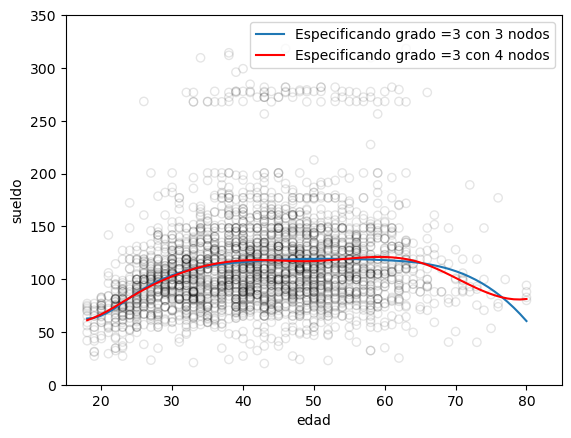

In [23]:
# Ahora obtendremos un gráfico con solo 70 observaciones
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Haciendo algunas predicciones
pred1 = fit1.predict(dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", {"xp": xp}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# Dibujamos los splines y las bandas de error
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Especificando grado =3 con 3 nodos')
plt.plot(xp, pred2, color='r', label='Especificando grado =3 con 4 nodos')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('edad')
plt.ylabel('sueldo')
plt.show()

Sabemos que el comportamiento de los polinomios que se ajustan a los datos tiende a ser errático cerca de los límites, y tal variabilidad puede ser peligrosa. Estos problemas también los pueden sufrir en cierto modo los splines de ajuste, ya que los polinomios usados para encajar en los subintervalos extremos se pueden llegar a comportar aún más salvajemente que los polinomios globales correspondientes en esa región. Para suavizar el polinomio más allá de los nodos de los extremos del intervalo, utilizaremos un tipo especial de spline conocido como **Spline Natural** (con continuaciones lineales a partir de los extremos).

Una spline cúbica natural agrega dos restricciones adicionales; a saber, que la función deberá tener derivada segunda nula en los nodos extremos.

In [24]:
# Generando un spline cúbico natural 
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

# Predicciones sobre el conjunto de validación
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculando el valor del error cuadrático medio RMSE
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)

39.44823813743623


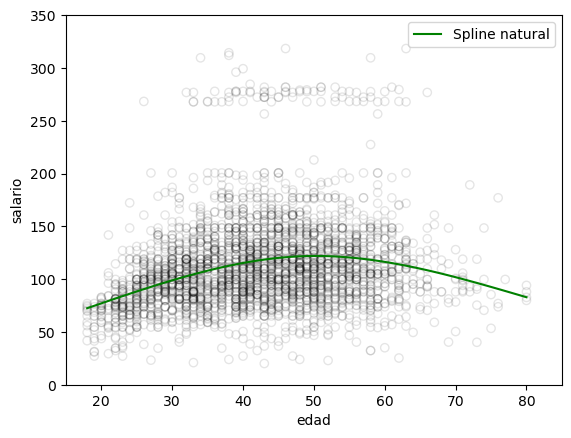

In [25]:
# Ahora obtendremos un gráfico con solo 70 observaciones
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# dibujamos el spline
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Spline natural')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('edad')
plt.ylabel('salario')
plt.show()

### Elegir el número y la ubicación de los nodos

Cuando encajamos un spline, ¿dónde debemos colocar los nodos? Un lugar potencial sería el área de alta variabilidad, porque en esas regiones los coeficientes polinómicos pueden cambiar rápidamente. Por lo tanto, una opción es colocar más nodos en lugares donde percibimos o intuimos que la función puede variar más rápidamente, y colocar menos nodos donde parece más estable.

Si bien esta opción puede funcionar bien, en la práctica es común colocar nodos de manera uniforme. Una forma de hacerlo es especificar los grados de libertad deseados y luego hacer que el software coloque automáticamente el número correspondiente de nodos en cuantiles uniformes de los datos.

Otra opción es probar diferentes números de nodos y ver cuál produce la curva más atractiva, aunque también se podrían emplear técnicas automatizadas (tipo algoritmos genéticos o de tipo evolutivo) para la optimización, tanto del número de nodos como de la colocación de los mismos.

Un enfoque más objetivo y plausible podría ser el de utilizar la denominada [`validación cruzada`](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada), ya que con este método:

* eliminamos una parte de los datos,
* ajustamos una spline con un cierto número de nodos a los datos restantes y, a continuación,
* usamos la spline para hacer predicciones para la porción retenida.

Repetimos este proceso varias veces hasta que cada observación se ha omitido una vez, y luego calculamos el RMSE general validado de forma cruzada. Este procedimiento se puede repetir para diferentes números de nodos. Luego se elige el valor de $K$ que da el RMSE más pequeño.

# Comparación de splines de regresión con la regresión polinómica

Las splines de regresión a menudo dan mejores resultados que la regresión polinómica. Esto se debe a que, a diferencia de los polinomios, que deben usar un polinomio de alto grado para producir ajustes flexibles, las splines introducen flexibilidad al aumentar el número de nodos, pero manteniendo el grado fijo.

En general, este enfoque produce estimaciones más estables. Las splines también nos permiten colocar más nodos, y por lo tanto poseerán más flexibilidad sobre regiones donde la función parece estar cambiando rápidamente, y menos nodos donde la función parece más estable. La flexibilidad adicional en el polinomio produce resultados indeseables en los límites, mientras que la spline cúbica natural todavía proporciona un ajuste razonable a los datos.

![imagen.png](compare.png)

## Notas finales

En este notebook, aprendimos sobre los splines de regresión y sus beneficios sobre la regresión lineal y polinómica. Otro método para producir splines se llama splines suavizantes y funciona de manera similar a la denominada [regularización de Ridge/Lasso](https://es.wikipedia.org/wiki/LASSO_(estad%C3%ADstica)), ya que penaliza tanto la [función de pérdida](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_p%C3%A9rdida#:~:text=En%20estad%C3%ADstica%2C%20teor%C3%ADa%20de%20la%20decisi%C3%B3n%20y%20econom%C3%ADa%2C,en%20econom%C3%ADa%20se%20expresan%20normalmente%20en%20t%C3%A9rminos%20monetarios.) como la [función de suavizado](https://es.wikipedia.org/wiki/Alisado). Puedes leer más sobre esto en el libro ['Introducción al aprendizaje estadístico'](https://rubenfcasal.github.io/aprendizaje_estadistico/index.html). Puede implementar estos métodos en conjuntos de datos con alta variabilidad y notar la diferencia.